In [1]:
# Dies ist ein Jupyter-Python-Notebook zum Experimentieren mit Geodaten für Hamburg, um
# die Belastung durch die in Folge der sogenannten "Werberechtsverträge" von 2007 auf
# öffentlichem Grund installierten Außenwerbeanlagen zu quantifizieren.

# Der zugrundeliegende Datensatz reicht bis in die Zeit der ersten Litfaßsäulen zurück,
# ist aber sehr detailliert und erlaubt es, die stark störenden Typen von den nicht störenden
# zu unterscheiden. Außer Standort und Art sind auch Betreiber, Aufstelldatum uvm. verzeichnet.

# Die Verwendung erfordert lediglich den Quellenvermerk (Lizenz https://www.govdata.de/dl-de/by-2-0)
# https://metaver.de/trefferanzeige?cmd=doShowDocument&docuuid=0095A542-4D26-474D-BBC2-C95B87622E06
# Quellenvermerk: Freie und Hansestadt Hamburg, Behörde für Verkehr und Mobilitätswende, (BVM)

# Das Stöbern im Geodatenportal lohnt sich! Es enthält eine Menge interessanter Datensätze,
# die sich auch sinnvoll verknüpfen lassen.

#
# !!! ACHTUNG !!! Work in progress - 2023-01-28
#
# Es haben sich einige Probleme mit der Datenqualität gezeigt. Wir sind dabei, einen Abgleich
# vorzunehmen, um die Abweichungen von der Realität festzustellen.
#
# Danke, BVM! Auf diese Zahlen hatten wir uns lange Zeit verlassen.
#

In [2]:
# Auswertung1.ipynb
# kumulativer Plot nach Aufstelldatum und Betreiber; Beginn der Routenplanungs-Experimente

In [3]:
# Etwas Autocompletion
%config IPCompleter.greedy=True

In [4]:
import os
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely import wkt

from pyproj import CRS

# Darstellung mit Matplotlib
import matplotlib.pyplot as plt

# osmnx soll cache anlegen
ox.config(log_console=False, use_cache=True)

import sklearn
import scipy

# Routenplanung und so
import networkx as nx

from collections import defaultdict

# Grafik
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch

In [5]:
wa = gpd.read_file("~/data/wa_gml_current.xml")

In [6]:
# Zum abgleich mit vorherigem Abruf der Daten - um herauszufinden, ob alte Analoge Anlagen gelöscht werden
# wa_old = gpd.read_file("~/data/wa_gml_current.xml.old")

In [7]:
# Datensatz etwas aufräumen:

for ww in [wa]: # , wa_old]:
 # Kategorielle Datentypen kennzeichnen
 ww['typ'] = ww['typ'].astype('category')
 # In manchen Einträgen ist ein Leerzeichen zuviel, siehe: # set(wa['bezirk'])
 ww['bezirk'] = ww['bezirk'].str.rstrip()
 ww['bezirk'] = ww['bezirk'].astype('category')
 ww['stadtteil'] = ww['stadtteil'].astype('category')
 ww['eigentuemer'] = ww['eigentuemer'].astype('category')
 # Fehlende Werte (null values) sind bei der Verarbeitung in Pandas u.U. nervig
 ww['anlagenstatus'] = ww['anlagenstatus'].fillna("N.A.")
 ww['anlagenstatus'] = ww['anlagenstatus'].astype('category')
 # Aufbaudatum ist ein Datetime
 ww['aufbaudatum'] = pd.to_datetime(ww['aufbaudatum'])

# Geometry-Attribut ist bereits richtig gesetzt

In [8]:
# Koordinatensystem steht in den Metadaten, sollte auch richtig gesetzt worden sein,
# geht aber manchmal verloren, keine Ahnung warum (check: wa.crs is None => True).
# Just in case:
wa = wa.set_crs("epsg:25832")
# wa_old = wa_old.set_crs("epsg:25832")

In [9]:
# check: # wa.dtypes
# check: wa.crs is None?
# wa.crs # sollte EPSG:25832 sein

In [10]:
# ACHTUNG!!! zumindest einige der "Fahrgastunterstand"-Einträge beziehen sich bloß auf den Unterstand selbst!
# Aber anscheinend nicht immer. In welchen Fällen das zutrifft, müssen wir noch herausfinden.

# Bis dahin ist keine vernünftige Auswertung möglich :-(

len(wa[wa.typ=='Fahrgastunterstand'])

2207

In [11]:
len(wa[wa.typ=='Stadtinformationsanlage zu Fahrgastunterstand'])

602

In [12]:
# Hamburg + ein rechteckiges Stück Umland, Netzwerk der Autostraßen
# (Auch interessant: Landschaftstypen, Gebäudegeometrien; ...)
# Geduld. Laden und Plotten dieses Graphen kann etwas dauern
# hamburg = ox.load_graphml(os.path.expanduser("~/data/hh-stadtgebiet-box-drive.graphml"))
# ox.plot_graph(hamburg)

In [13]:
# Jetzt kann's losgehen!

In [14]:
# Vor 2000 gab es nur harmlose, nicht aufdringliche Anlagentypen
set(wa[wa.aufbaudatum < np.datetime64('2001-01-01')].typ)

{'Litfaßsäule', 'Uhrensäulen'}

In [16]:
# 2001 wurden die ersten Bushaltestellen mit Werbekästen versehen, allerdings noch ohne Scrollen.
# -> Interessant, sie heißen hier trotzdem nur "Fahrgastunterstand".
set(wa[wa.aufbaudatum < np.datetime64('2002-01-01')].typ)

{'Fahrgastunterstand', 'Litfaßsäule', 'Uhrensäulen'}

In [17]:
(set(wa.typ)) #, set(wa_old.typ))
# Um was es sich bei den "nan" Einträgen handelt, muss noch ermittelt werden
# (Satellitenbilder oder vorbeischauen).

{'City-Light-Säule',
 'Digital Board',
 'Digital Säule',
 'Fahrgastunterstand',
 'Litfaßsäule',
 'Mega-Light',
 'Stadtinformationsanlage',
 'Stadtinformationsanlage zu Fahrgastunterstand',
 'Uhrensäulen',
 nan}

In [18]:
# Diese 50 zweifelhaften Datenpunkte (alle übrigens ab 2000 aufgebaut) erstmal entfernen,
# bis wir wissen worum es sich handelt.
len(wa), len(wa[wa.typ.notnull()]) #, len(wa_old), len(wa_old[wa_old.typ.notnull()])

(5474, 5416)

In [19]:
wa_ohne_nan = wa[wa['typ'].notnull()]
# wa_old_ohne_nan = wa_old[wa_old['typ'].notnull()]

In [20]:
# Definiere harmlose Typen, um sie aus der Auswertung auszuschließen.
harmlos = {'Litfaßsäule', 'Uhrensäulen'}
# boese = set(wa_ohne_nan.typ).union(set(wa_old_ohne_nan.typ)) - harmlos
# und jetzt ohne FGU, um auf der sicheren Seite zu sein (2023-01)
boese = set(wa_ohne_nan.typ) - harmlos - {'Fahrgastunterstand'}

In [21]:
# Das sind die Anlagentypen mit Wechsellichttechnik und Wechsellichtbetrieb. Nennen wir sie "boese".
boese

{'City-Light-Säule',
 'Digital Board',
 'Digital Säule',
 'Mega-Light',
 'Stadtinformationsanlage',
 'Stadtinformationsanlage zu Fahrgastunterstand'}

In [22]:
wa_ab_2000 = wa_ohne_nan[(wa_ohne_nan['aufbaudatum'] >= np.datetime64('2000-01-01'))]
# wa_old_ab_2000 = wa_old_ohne_nan[(wa_old_ohne_nan['aufbaudatum'] >= np.datetime64('2000-01-01'))]

In [23]:
(len(wa_ab_2000)) #, len(wa_old_ab_2000))

4579

In [24]:
wa_boese = wa_ohne_nan[wa_ohne_nan['typ'].apply(lambda x: x in boese)]
# wa_old_boese = wa_old_ohne_nan[wa_old_ohne_nan['typ'].apply(lambda x: x in boese)]


In [25]:
(len(wa_boese)) #, len(wa_old_boese))

1894

In [26]:
# len(wa_old_boese[wa_old_boese['typ'].apply(lambda x: x.startswith('Mega'))])

In [27]:
len(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Mega'))])

15

In [28]:
# len(wa_old_boese[wa_old_boese['typ'].apply(lambda x: x.startswith('Digital'))])
len(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital'))])

174

In [29]:
len(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital B'))])

63

In [30]:
len(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Stadti'))])

1049

In [31]:
len(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital S'))])

111

In [32]:
# NB: bei 4000-5000 über die ganze Stadt verteilten Standorten konnten wir
# nur stichprobenartig überprüfen, wie akkurat die Daten sind. Stellt sich
# heraus, dass das nicht reichte ... danke BVM

len(wa_boese[wa_boese['aufbaudatum'] < np.datetime64('2010-01-01')])

# len(wa_old_boese[wa_old_boese['aufbaudatum'] < np.datetime64('2010-01-01')]))

604

In [33]:
wa_boese_neu = wa_boese[wa_boese['aufbaudatum'] < np.datetime64('2022-01-01')][wa_boese['aufbaudatum'] >= np.datetime64('2020-04-01')]

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [34]:
wa_boese_neu

gml_id         bezirk         stadtteil  \
645   DE.HH.UP_WERBEANLAGEN_30245            NaN         St. Georg   
646   DE.HH.UP_WERBEANLAGEN_30246            NaN        Winterhude   
647   DE.HH.UP_WERBEANLAGEN_30247            NaN              Horn   
648   DE.HH.UP_WERBEANLAGEN_30248            NaN        Bahrenfeld   
649   DE.HH.UP_WERBEANLAGEN_30249            NaN        Bahrenfeld   
...                           ...            ...               ...   
5421  DE.HH.UP_WERBEANLAGEN_35021  Hamburg-Mitte  Hamburg-Altstadt   
5424  DE.HH.UP_WERBEANLAGEN_35024  Hamburg-Mitte         St. Pauli   
5432  DE.HH.UP_WERBEANLAGEN_35032  Hamburg-Mitte          Neustadt   
5440  DE.HH.UP_WERBEANLAGEN_35040  Hamburg-Mitte          Neustadt   
5448  DE.HH.UP_WERBEANLAGEN_35048   Hamburg-Nord        Hohenfelde   

                                                typ  \
645                                City-Light-Säule   
646                                City-Light-Säule   
647                                City-Light-Säule   
648                                City-Light-Säule   
649                                City-Light-Säule   
...                                             ...   
5421                        Stadtinformationsanlage   
5424                        Stadtinformationsanlage   
5432                        Stadtinformationsanlage   
5440                        Stadtinformationsanlage   
5448  Stadtinformationsanlage zu Fahrgastunterstand   

                                    standort                eigentuemer  \
645                 Amsinckstr./Spaldingstr.  DSM Werbetr. GmbH & Co.KG   
646                       Borgweg/Wiesendamm  DSM Werbetr. GmbH & Co.KG   
647     Horner Landstraße / Schurzallee Nord  DSM Werbetr. GmbH & Co.KG   
648          Luruper Chaussee 127 / Kielkamp  DSM Werbetr. GmbH & Co.KG   
649   Schnackenburgallee / Ottensener Straße  DSM Werbetr. GmbH & Co.KG   
...                                      ...                        ...   
5421             Haltestelle , Jungfernstieg                  Wall GmbH   
5424                Haltestelle , Reeperbahn                  Wall GmbH   
5432                Haltestelle , Colonnaden                  Wall GmbH   
5440                Haltestelle , Neuer Wall                  Wall GmbH   
5448               Haltestelle , Schwanenwik                  Wall GmbH   

     aufbaudatum anlagenstatus                        geometry  
645   2020-04-01          N.A.  POINT (567049.884 5933725.997)  
646   2020-04-14          N.A.  POINT (567230.973 5938411.774)  
647   2020-07-28          N.A.  POINT (570707.481 5934365.162)  
648   2020-10-15          N.A.  POINT (559164.195 5936420.948)  
649   2020-11-02          N.A.  POINT (560142.457 5937695.119)  
...          ...           ...                             ...  
5421  2020-07-07         Aktiv  POINT (565863.726 5934146.350)  
5424  2020-09-28         Aktiv  POINT (563480.828 5933849.088)  
5432  2020-05-18         Aktiv  POINT (565596.051 5934648.835)  
5440  2020-05-18         Aktiv  POINT (565545.689 5934030.917)  
5448  2021-01-12         Aktiv  POINT (567386.165 5935488.111)  

[157 rows x 9 columns]

In [35]:
wa_boese.groupby(['eigentuemer', 'anlagenstatus']).count()['gml_id']
# 866 wurden von Ströer (DSM) aufgestellt, 3109 von JCDecaux (Wall).
# Davon sind 21 wohl "vorübergehend abgebaut". Bei Ströer fehlt diese Angabe.

eigentuemer                anlagenstatus         
DSM Werbetr. GmbH & Co.KG  Aktiv                        0
                           N.A.                       845
                           Vorübergehend abgebaut       0
Wall GmbH                  Aktiv                     1044
                           N.A.                         0
                           Vorübergehend abgebaut       5
Name: gml_id, dtype: int64

In [36]:
# wa_old_boese.groupby(['eigentuemer', 'anlagenstatus']).count()['gml_id']

In [37]:
# Wann ist das alles geschehen? Erstellen wir gleich mal eine Grafik, die die Belastung in HH durch Außenwerbung
# kumuliert zeigt. (Wir gehen davon aus, dass alle Anlagen weiterhin vorhanden sind - stichprobenartige
# Prüfungen bejahen dies: der Datensatz scheint weitgehend aktuell und akkurat zu sein.)

# (Update: Ersetzte Anlagen werden entfernt, so dass das historische Bild verzerrt wird. Mehrmalige Bitten bei der
# für den Datensatz zuständige Behörde, diese Information im Datensatz bitte nicht zu verschleiern sondern akkurat
# abzubilden, haben nicht gefruchtet)

In [44]:
daily2 = {}
for art in ['digital', 'motorisiert?']:
    gefiltert = wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital') if art == 'digital' else not x.startswith('Digital'))]
    sortiert = gefiltert.set_index('aufbaudatum').sort_index()
    sortiert['count'] = sortiert.groupby(['aufbaudatum']).cumcount() + 1
    counts = sortiert['count'].reset_index().groupby(['aufbaudatum']).agg('max')
    daily2[art] = counts
combined2 = pd.merge(daily2['digital'], daily2['motorisiert?'], how='outer', on='aufbaudatum').fillna(0).rename(columns={'count_x':'digital', 'count_y':'motorisiert?'})
cumsums2 = combined2.sort_index().cumsum().copy()

In [45]:
cumsums2

digital  motorisiert?
aufbaudatum                       
2003-05-15       0.0           1.0
2007-03-05       0.0           4.0
2008-08-11       0.0          40.0
2008-08-13       0.0          41.0
2008-08-18       0.0          70.0
...              ...           ...
2022-09-19     171.0        1719.0
2022-09-20     172.0        1719.0
2022-09-21     173.0        1719.0
2022-09-23     174.0        1719.0
2022-10-04     174.0        1720.0

[760 rows x 2 columns]

In [46]:
daily = {}
for eigentuemer in ['Wall', 'DSM']:
    gefiltert = wa_boese[wa_boese['eigentuemer'].str.contains(eigentuemer)]
    sortiert = gefiltert.set_index('aufbaudatum').sort_index()
    sortiert['count'] = sortiert.groupby(['aufbaudatum']).cumcount() + 1
    counts = sortiert['count'].reset_index().groupby(['aufbaudatum']).agg('max')
    daily[eigentuemer] = counts

In [47]:
combined = pd.merge(daily['DSM'], daily['Wall'], how='outer', on='aufbaudatum').fillna(0).\
   rename(columns={'count_x':'DSM', 'count_y':'Wall'})

In [48]:
cumsums = combined.sort_index().cumsum().copy()

In [49]:
# Erste Auswertung (nicht geographisch, zeigt nur die wachsende Anzahl)

def auswertung_kumulative_grafik(cumsums):
    fig, ax = plt.subplots(figsize = (23,16))
    areaplot = cumsums.plot.area(ax=ax, fontsize=24, color=["darkblue", "darkred"], grid=True)
 
    plt.legend(loc=2, prop={'size': 24})
    ax.set_xlabel("")
    fig.show()
    
    # 'Anzahl der Außenwerbeanlagen* in HH, aufgeschlüsselt nach Betreiber'
    # * = nur die neuartigen, aufdringlichen Typen    
    fig.savefig('kumulativ_transparent.png', transparent=True) #, facecolor="white")

# Aufrufen:
# auswertung_kumulative_grafik()

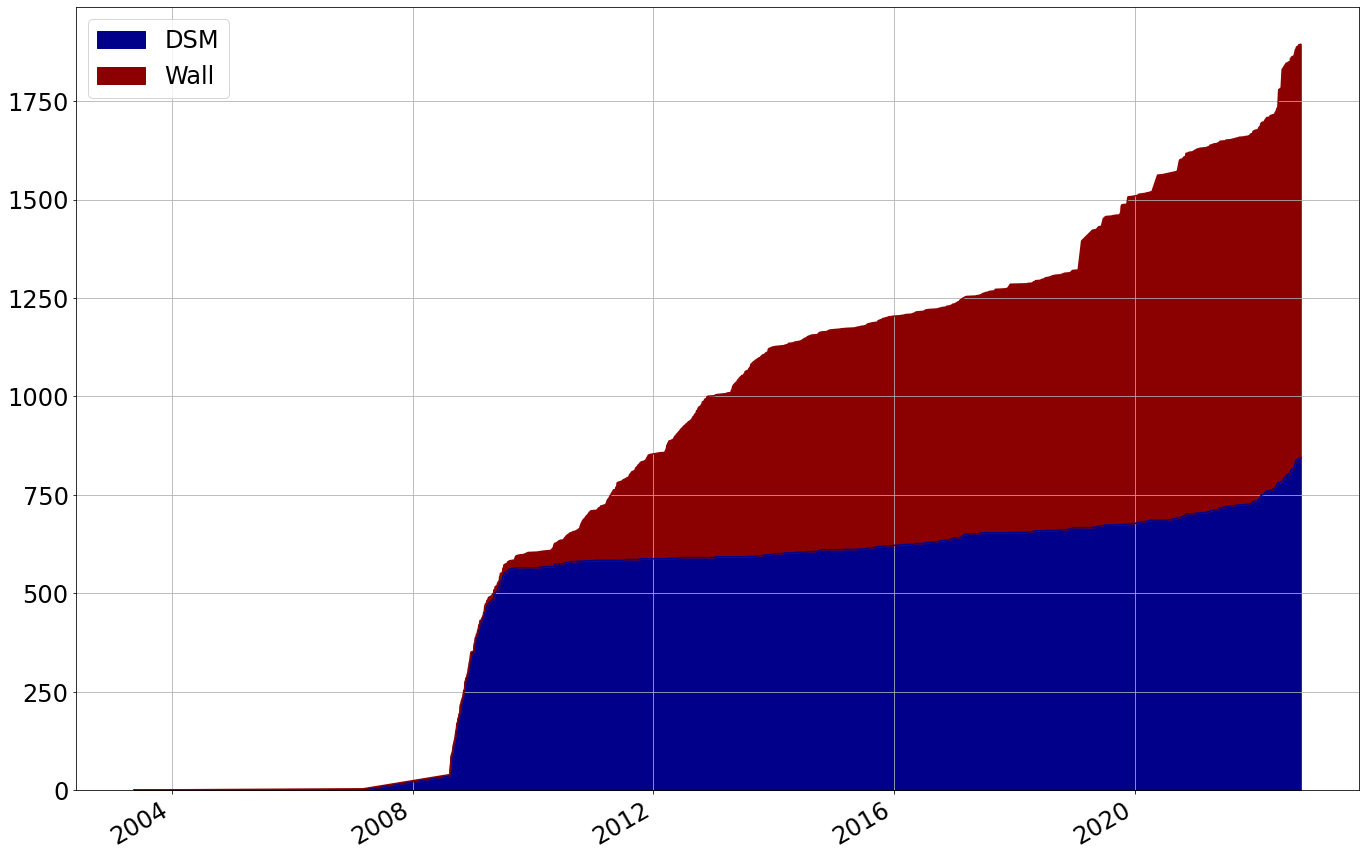

In [50]:
auswertung_kumulative_grafik(cumsums)

# Der Trend bleibt natürlich auch nach Herausfiltern aller FGUs (Fahrgastunterstände) der Gleiche ...

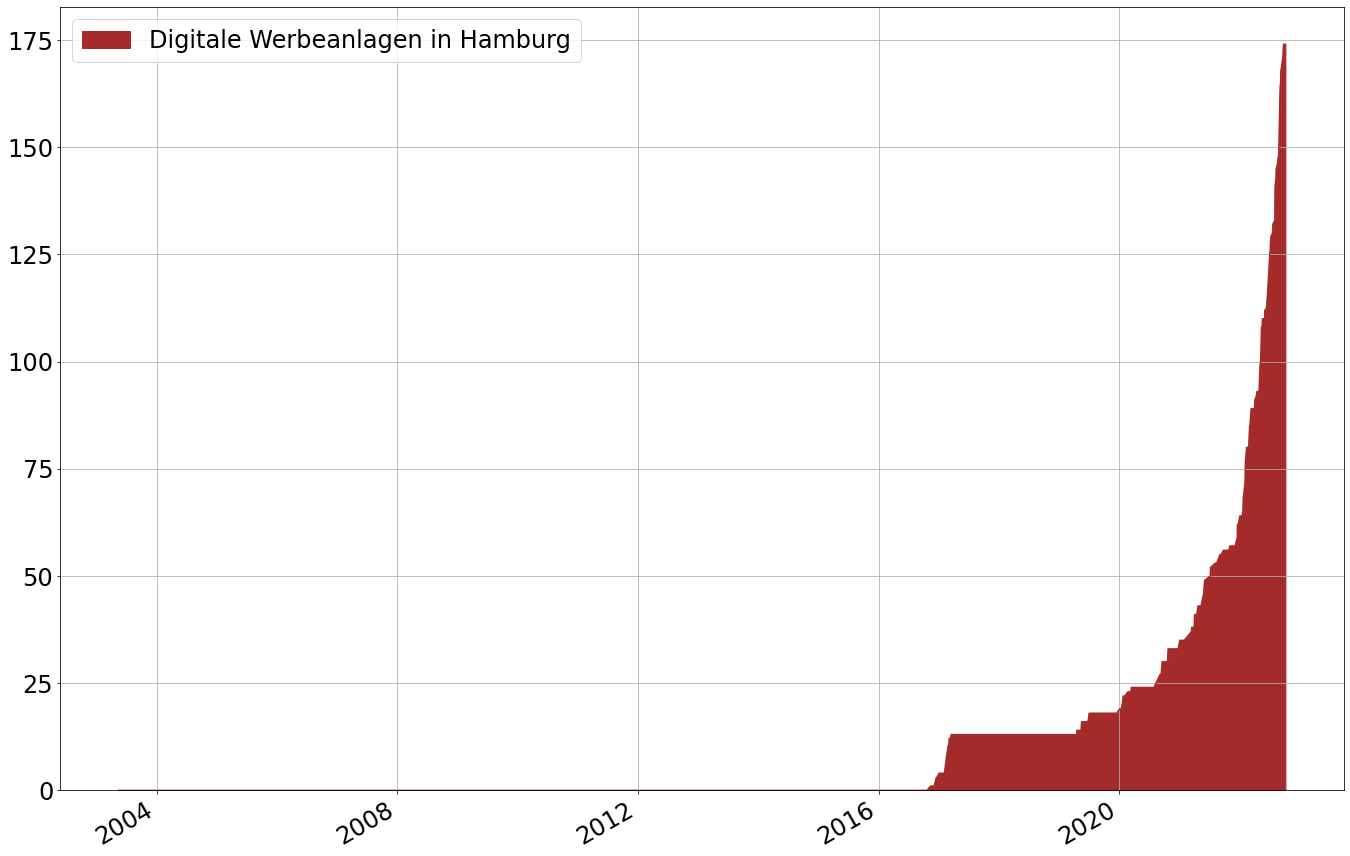

In [51]:
fig, ax = plt.subplots(figsize = (23,16))
areaplot = cumsums2["digital"].plot.area(
    ax=ax, fontsize=24, color=["brown"], grid=True, label='Digitale Werbeanlagen in Hamburg')
 
plt.legend(loc=2, prop={'size': 24})
ax.set_xlabel("")
(x0,x1) = ax.get_xlim()
# ax.set_xlim(x0, x0 + (x1-x0)*23/24) # how to get these values?
fig.show()
    
fig.savefig('kumulativ_digital.png', transparent=True) #, facecolor="white")
fig.savefig('kumulativ_digital_white_bg.png', transparent=False, bbox_inches="tight")

# Auch das scheint nicht akkurat zu sein, digitale CLPs sind im Datensatz NICHT von analogen zu unterscheiden!!
# Der Trend stimmt, besser sind aber die Zahlen aus der Drucksache 22/9057 und Drucksache 22/10421
# der Bürgerschaft HH.

In [52]:
# Nun das Straßennetz laden
%time hamburg = ox.load_graphml(os.path.expanduser("~/data/hh-stadtgebiet-box-drive.graphml"))

CPU times: user 11.4 s, sys: 420 ms, total: 11.8 s
Wall time: 11.9 s


In [53]:
# print(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital B'))].aufbaudatum.to_string())

In [54]:
stadtverbloedungsanlagen_clp = wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Stadtinformati'))]
# xfoo.set_index('aufbaudatum').sort_index()
# print(xfoo[(xfoo['aufbaudatum'] >= np.datetime64('2019-01-01'))].aufbaudatum.to_string())


In [55]:
len(hamburg.nodes.keys()), len(hamburg.edges.keys())

(33112, 79484)

In [98]:
# Kreuzungsgeometrie vereinfachen: wir bauen hier kein Navi. Ein Punkt pro Kreuzung ist aussagekräftiger für den Zweck.
crs = '+proj=cea +lat_ts=55.0'
%time \
G2 = ox.consolidate_intersections(ox.project_graph(hamburg, crs), tolerance=10, rebuild_graph=True, dead_ends=True)
hamburg = G2

# Kann 1-2 Minuten dauern und evtl. kommt eine komische Fehlermeldung, die ist wurscht:
# FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
#  G2 = ox.consolidate_intersections(

<timed exec>:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


TypeError: networkx.classes.digraph.DiGraph.add_node() got multiple values for keyword argument 'osmid_original'

In [57]:
# wa_boese.crs ist EPSG:25832
# hamburg.graph['crs'] ist epsg:4326
# Zum Verknüpfen der beiden Datensätze ist eine Reprojektion auf das andere CRS nötig.
%time wa_boese_projected = wa_boese.to_crs('epsg:4326')
wa_boese = wa_boese_projected



CPU times: user 276 ms, sys: 16.3 ms, total: 293 ms
Wall time: 326 ms


In [58]:
%time stadtverbloedungsanlagen_clp = stadtverbloedungsanlagen_clptverbloedungsanlagen_clp.to_crs('epsg:4326')

NameError: name 'stadtverbloedungsanlagen_clptverbloedungsanlagen_clp' is not defined

In [59]:
# Warum ist das nötig? Sind die Daten noch nicht in das angegebene System projiziert?
# Keine Ahnung. So funktioniert's jedenfalls:
%time hamburg = ox.project_graph(hamburg, to_crs="epsg:4326")

CPU times: user 28.6 s, sys: 61.3 ms, total: 28.7 s
Wall time: 29.2 s


In [60]:
# Zu jeder Werbeanlage den nächsten Nachbar-Knotenpunkt im Straßennetz suchen:
(nns, nndistances) = ox.distance.nearest_nodes(hamburg,
                           X=np.array(list(pt.x for pt in wa_boese['geometry'])),
                           Y=np.array(list(pt.y for pt in wa_boese['geometry'])), return_dist=True)

In [61]:
# Das geht auch: manche Anlagen sind näher an Kanten (Straßen ohne Kreuzungen) als an irgendwelchen Knoten.
# Aber siehe unten, warum es problematisch ist, das so zu berechnen - wir überlegen uns noch was Besseres.

In [62]:
# Geopandas mag Abstände nicht in einem "geographic CRS" berechnen.
# Muss eines auswählen, das Abstände möglichst getreu abbilden soll.
# Vorsicht, viel mehr Berechnungsaufwand als nearest_nodes und der Nutzen ist eher gering.
# Je nachdem reicht vielleicht auch ersteres.
crs = '+proj=cea +lat_ts=55.0'
(nes, nedistances) = ox.distance.nearest_edges(ox.project_graph(hamburg, crs),
                           X=np.array(list(pt.x for pt in wa_boese['geometry'].to_crs(crs))),
                           Y=np.array(list(pt.y for pt in wa_boese['geometry'].to_crs(crs))), return_dist=True)

In [63]:
# nns ist ein Paar von Listen (node_ids, distances). Die distances sind eigentlich egal
# es kann natürlich sein, dass ein Teil an einer freien Strecke steht. Dann ordnen wir
# es momentan trotzdem dem nächsten Node zu (note: Kreuzungen = Nodes mit street_count > 1)
# und außerdem haben wir auch noch nes zur verfügung.

In [64]:
nnwadict = defaultdict(list)
newadict = defaultdict(list)
for (wa, (nn, ne)) in zip(list(wa_boese['gml_id']), zip(nns, nes)):
    nnwadict[nn].append(wa)
    newadict[ne].append(wa)

In [65]:
# nnwadict

In [66]:
# Für eine "realistische" Routenplanung annotieren
# highway_speeds = {'residential': 30, 'secondary': 50, 'tertiary': 50} - sind im OSM-Datensatz schon vorhanden
%time hamburg = ox.add_edge_speeds(hamburg)

CPU times: user 9.11 s, sys: 25.6 ms, total: 9.13 s
Wall time: 9.58 s


In [67]:
%time hamburg = ox.add_edge_travel_times(hamburg)

CPU times: user 4.45 s, sys: 6.61 ms, total: 4.46 s
Wall time: 4.48 s


In [68]:
# Das ergibt zwei neue Pandas-Dataframes
nodes, edges = ox.graph_to_gdfs(hamburg, nodes=True, edges=True)

In [69]:
# Attribut machen, das die Anzahl der zugeordneten Werbeanlagen zählt
%time nodes['badness'] = nodes.index.map(lambda idx: nns.count(idx))

CPU times: user 1.75 s, sys: 6.59 ms, total: 1.76 s
Wall time: 1.77 s


In [70]:
%time edges['badness'] = edges.index.map(lambda idx: len(newadict[idx]))

CPU times: user 670 ms, sys: 12 µs, total: 670 ms
Wall time: 671 ms


In [71]:
nodes_i = nodes.reset_index()
edges_i = edges.reset_index()

In [72]:
# edges['highway'] # was ist es für eine Straße (Schnellstraße, Wohnstraße, ...)
# edges['badness'] # nodes[['badness', 'street_count']]

In [73]:
# Als Beispiel nehmen wir einen wichtigen Ort in Hamburg, das Hauptgebäude der Uni an der Edmund-Siemers-Allee:
loc_esa = (53.56277, 9.98794)
# direkt daneben, zentral gelegen
# loc_dammtor = (53.56097,9.99037)
loc_dammtor = (53.5602, 9.9910)
loc_schlump = (53.5678, 9.9697)
# Hauptbahnhof Parkplatz
loc_hbf_p = (53.55436,10.00720)
# CCH
loc_cch = (53.56092,9.98851)
# Hagenbecks Tierpark
loc_hagenbeck = (53.5968,9.9394)
# oder das DESY
loc_desy = (53.5756, 9.8791)
# oder ein Wohnviertel
loc_wohn1 = (53.5672,9.8393)

# Wähle zwei und simuliere eine Fahrt (Auto) durch die Stadt ...
loc_start = loc_esa
loc_dest = loc_desy

In [74]:
# Nun können wir mit osmnx Routen berechnen -- und auswerten.
(node_start, dist1) = ox.distance.nearest_nodes(hamburg, X=loc_start[1], Y=loc_start[0], return_dist=True)
(node_dest, dist2)  = ox.distance.nearest_nodes(hamburg, X=loc_dest[1], Y=loc_dest[0], return_dist=True)
# Plausibilitäts-Check: dist1, dist2 (in m) sollten nicht zu groß sein

(node_hbf, dist_hbf) = ox.distance.nearest_nodes(hamburg, X=loc_hbf_p[1], Y=loc_hbf_p[0], return_dist=True)
(node_cch, dist_cch) = ox.distance.nearest_nodes(hamburg, X=loc_cch[1], Y=loc_cch[0], return_dist=True)

In [75]:
dist1, dist2, dist_cch, dist_hbf

(119.63147409482107, 136.00479456229812, 95.02778101984606, 14.019720253898356)

In [76]:
route1 = nx.shortest_path(hamburg, node_start, node_dest, weight = 'travel_time')

In [77]:
len(route1)

80

In [78]:
sum(ox.utils_graph.get_route_edge_attributes(hamburg, route1, "travel_time")) / 60.0
# in Minuten

10.783333333333335

In [79]:
sum(ox.utils_graph.get_route_edge_attributes(hamburg, route1, "length")) / 1000.0
# in Kilometern

8.580523036266456

In [80]:
nx.set_node_attributes(hamburg, nodes['badness'], name='badness') # ignored by most functions in ox, set anyway
nx.set_edge_attributes(hamburg, edges['badness'], name='badness')

In [81]:
# Dies ist noch nicht das interessante Ergebnis, es fehlen viele an den Knotenpunkten
sum(ox.utils_graph.get_route_edge_attributes(hamburg, route1, "badness"))

15

In [82]:
# Es fehlt aber einiges mit nur den nächsten Kanten. Und zwar diese hier:

# Nehmen wir lieber erstmal in Kauf, einige der an den Kanten gelegenen Punkte zu verlieren,
# wenn sie zufällig näher an einem weiter entfernten Knoten sind als an einem der Endpunkte
# der Kante und daher hier nicht richtig zugeordnet werden

# (können bei späterer Verbesserung der Auswertung wieder hinzugefügt werden und werden das
# Ergebnis nur noch schlimmer machen ...) - die Karte weiter unten zeigt, dass mindestens 1-2
# Stück tatsächlich noch hinzukämen.

# Das Beste wäre eine Suche nach allen Knoten und Straßensegmenten in einem gewissen Radius
# und mit Sichtlinien-Test (erfordert Gebäudegeometrien, die sind bei OSM auch verfügbar).

# Immerhin ist wenn man nur das eine oder das andere nimmt, durch unsere Berechnungsvorschrift
# bei der Zuordnung (nnwadict) sichergestellt, dass nichts doppelt gezählt wird.

# Also erstmal die einfache Variante, die die Anzahl Anlagen an der Route noch unterschätzt:

sum(nodes_i[nodes_i["osmid"].apply(lambda osmid: osmid in route1)]['badness'])

34

In [83]:
# sum(ox.utils_graph.get_route_edge_attributes(hamburg, route1, "length")) / sum(nodes_i[nodes_i["osmid"].apply(lambda osmid: osmid in route1)]['badness'])

In [84]:
# Das ist wirklich übel. >= 63 Werbeanlagen an einer 9km langen Route durch die Stadt, ein durchaus normaler Weg.

# Eventuell sind das noch nicht alle, weil einige der 29 an den Kanten gelegenen hier eventuell nicht mit drin sind.

In [85]:
uvpath = [x for x in zip(route1[:-1], route1[1:])]
edge_path = [hamburg.edges[(u, v, 0)] for (u,v) in uvpath]

In [86]:
bbox_n = max(loc_dest[0], loc_start[0])+0.01
bbox_s = min(loc_dest[0], loc_start[0])-0.01
bbox_w = min(loc_start[1], loc_dest[1])-0.02
bbox_e = max(loc_start[1], loc_dest[1])+0.02
bbox = (bbox_n, bbox_s, bbox_e, bbox_w)
from shapely.geometry import Polygon
bbox_shape = Polygon([(bbox_w,bbox_s), (bbox_w,bbox_n), (bbox_e,bbox_n), (bbox_e,bbox_s)])
bbox_shape.area

0.004886417199999553

In [87]:
bbox_shape.bounds

(9.8591, 53.55277, 10.00794, 53.5856)

In [88]:
# Datensatz geographisch in bounding box der zu erzeugenden Grafik croppen
wa_crop = wa_boese[wa_boese['geometry'].apply(lambda p: bbox_shape.contains(p))]

In [89]:
# empty => quick result:  fig, ax = plt.subplots(figsize=(24,24))

fig, ax = ox.plot_graph(hamburg, 
                        figsize=(24, 24), node_size=1,
                        bbox=bbox,                       
                        show=False, close=False)

wa_crop['geometry'].plot(ax=ax, color="cyan", alpha=0.5)

nodes_i[nodes_i['osmid'] == node_start].geometry.plot(ax=ax , c="red")
nodes_i[nodes_i['osmid'] == node_dest].geometry.plot(ax=ax , c="red")#, s=4.0)

for e in edge_path:
    gs = gpd.GeoSeries(e['geometry'])
    gs.plot(ax=ax, color="lightgreen", linewidth=3.0, aspect = None)
    
for (u,v) in uvpath:
    for gml_id in newadict[(u,v,0)]:
        # print(gml_id)
        # in fact, there should be one per result
        evil_point = list(wa_boese[wa_boese['gml_id'] == gml_id]['geometry'])[0]
        ax.scatter(y=evil_point.y, x=evil_point.x, color="orange", alpha=0.8)

for u in route1:
    for gml_id in nnwadict[u]:
        # print(gml_id)
        evil_point = list(wa_boese[wa_boese['gml_id'] == gml_id]['geometry'])[0]
        ax.scatter(y=evil_point.y, x=evil_point.x, color="yellow", alpha=0.8)
        
fig.show()

fig.savefig('routenplan.png', transparent=False, facecolor="white")

# Punkte könnten ruhig größer sein (Matplotlib-API macht das nicht so einfach, wie es sein sollte)
# TODO Legende
# TODO Sichtbarkeitsbereiche abschätzen und "freie" Wegstrecken identifizieren

In [90]:
# 63 von den aggressiven Dingern, das ist ziemlich viel.
# Wenn es nicht bei der einen Fahrt bleibt, kumuliert sich die Wirkung.

# Gibt es eine weniger belastete Route? Aufschluss gibt AuswertungCar.ipynb bzw. AuswertungBike.ipynb

In [91]:
fig, ax = ox.plot_graph(hamburg, 
                        figsize=(24, 24), node_size=1,
                        bbox=bbox,                       
                        show=False, close=False)

wa_crop['geometry'].plot(ax=ax, color="cyan", alpha=0.5)

(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital B'))]).plot(ax=ax , c="red")

<AxesSubplot:>

In [92]:
# wa_boese

In [93]:
(locy, locx) = ox.geocode("Edmund-Siemers-Allee 1")
(locx, locy)

bbox_n = locy+0.01
bbox_s = locy-0.01
bbox_w = locx-0.02
bbox_e = locx+0.02
bbox = (bbox_n, bbox_s, bbox_e, bbox_w)
from shapely.geometry import Polygon
bbox_shape = Polygon([(bbox_w,bbox_s), (bbox_w,bbox_n), (bbox_e,bbox_n), (bbox_e,bbox_s)])
bbox_shape.area

0.0007999999999998237

In [94]:
wa_crop = wa_boese[wa_boese['geometry'].apply(lambda p: bbox_shape.contains(p))]

In [95]:
len(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Fahrgas'))])

0

In [96]:
set(wa_boese['typ'])

{'City-Light-Säule',
 'Digital Board',
 'Digital Säule',
 'Mega-Light',
 'Stadtinformationsanlage',
 'Stadtinformationsanlage zu Fahrgastunterstand'}

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

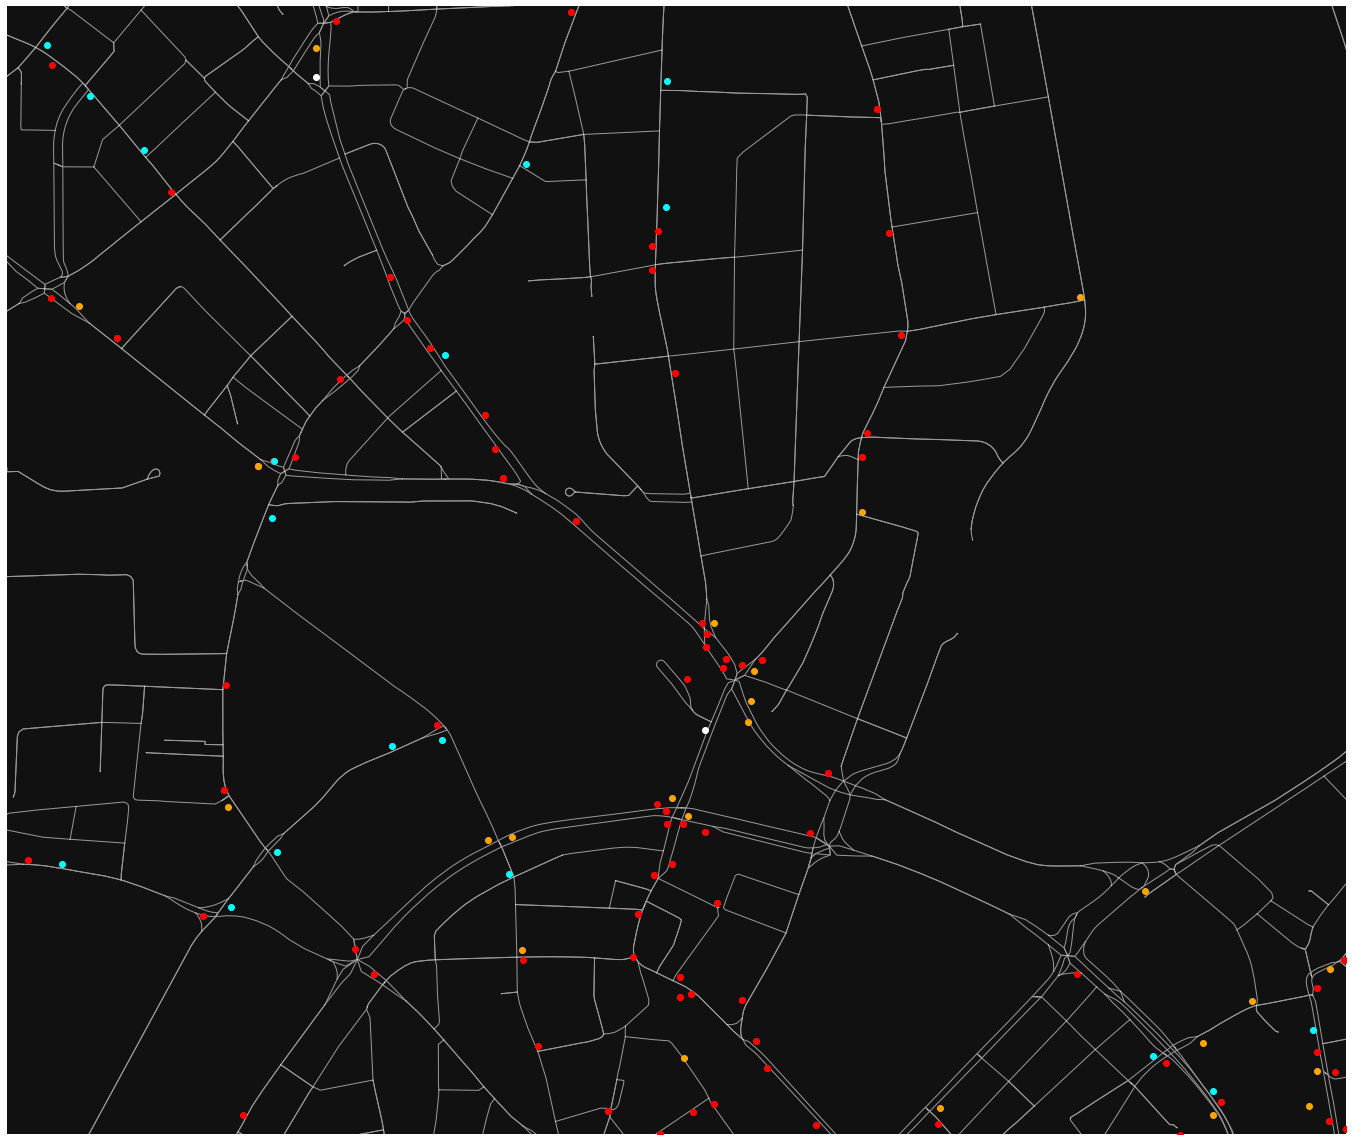

In [97]:
(locy, locx) = ox.geocode("Edmund-Siemers-Allee 1")
# (locy, locx) = ox.geocode("U Schlump")
(locx, locy)

bbox_n = locy+0.01
bbox_s = locy-0.01
bbox_w = locx-0.02
bbox_e = locx+0.02
bbox = (bbox_n, bbox_s, bbox_e, bbox_w)
from shapely.geometry import Polygon
bbox_shape = Polygon([(bbox_w,bbox_s), (bbox_w,bbox_n), (bbox_e,bbox_n), (bbox_e,bbox_s)])
bbox_shape.area

wa_crop = wa_boese[wa_boese['geometry'].apply(lambda p: bbox_shape.contains(p))]

fig, ax = ox.plot_graph(hamburg, 
                        figsize=(24, 24), node_size=1,
                        bbox=bbox,                       
                        show=False, close=False)

# wa_crop['geometry'].plot(ax=ax, color="cyan", alpha=0.5)

(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Stadtin'))]).plot(ax=ax , c="red")
(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital S'))]).plot(ax=ax , c="orange")
(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Digital B'))]).plot(ax=ax , c="white")
(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('City-Li'))]).plot(ax=ax , c="cyan")
(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Fahrgas'))]).plot(ax=ax , c="green")
(wa_boese[wa_boese['typ'].apply(lambda x: x.startswith('Mega'))]).plot(ax=ax , c="yellow")